In [1]:
from hashlib import sha256
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing, multiprocessing.pool
from functools import partial
import string
import random
random.seed(23)

# HyperLogLog

### What is it?
- algorithm to estimate the count of unique elements (cardinality)
- in other words: an approximate solution for the count-distinct problem

### Why not a regular set?
- with a set you can get the count exactly, but memory usage scales linearly with the number of unique elements

### Advantages
- constant space

### Use Case
- when you deal with a huge amount of elements
- count unique IPs that sent requests to a server
- count the number of unique searches of users
- count active users in app in a time period

# Implement Probabilistic Counting

In [2]:
class ProbabilisticCounting:
    
    def __init__(self):
        self.max_nr_of_leading_zeros = 0
        self.hash_function = lambda x: int(sha256(x.encode()).hexdigest(), 16)
        
    def _number_of_leading_zeros(self, number):
        i = 0
        while number & 1 == 0:
            number >>= 1
            i += 1
        return i
    
    def add(self, item):
        hash_value = self.hash_function(item)
        number_of_leading_zeros = self._number_of_leading_zeros(hash_value)
        if number_of_leading_zeros > self.max_nr_of_leading_zeros:
            self.max_nr_of_leading_zeros = number_of_leading_zeros
    
    def estimate_count(self):
        return 2 ** self.max_nr_of_leading_zeros
    
    def reset(self):
        self.max_nr_of_leading_zeros = 0

# Test the implementation

In [3]:
counter = ProbabilisticCounting()

counter.add("abc")
counter.estimate_count()

1

# Analyze the unique count estimation with a simulation

In [4]:
def create_random_inputs(n):
    random_inputs = []
    input_length = 20
    for _ in range(n):
        random_input = "".join(random.choice(string.ascii_lowercase) for _ in range(input_length))
        random_inputs.append(random_input)
    return random_inputs

In [5]:
def simulate_and_visualize(counter):
    real_counts = []
    estimated_counts = []
    confidence_intervals = []
    start_count = 0
    end_count = 10000
    step_size = 200
    trials = 100
    
    for n in range(start_count, end_count + step_size, step_size):
        estimated_counts_for_n = []
        
        for _ in range(trials):
            counter.reset()
            random_inputs = create_random_inputs(n)
            for random_input in random_inputs:
                counter.add(random_input)
            estimated_count = counter.estimate_count()
            estimated_counts_for_n.append(estimated_count)
            
        median_estimated_count = np.average(estimated_counts_for_n)
        confidence_interval = np.percentile(estimated_counts_for_n, 5)
            
        real_counts.append(n)
        estimated_counts.append(median_estimated_count)
        confidence_intervals.append(confidence_interval)
        
    plt.plot(real_counts, estimated_counts)
    plt.xlabel("True number of unique elements")
    plt.ylabel("Estimated number of unique elements")
    plt.plot(real_counts, real_counts, color="gray", linestyle="--")
    plt.fill_between(real_counts, (estimated_counts - np.array(confidence_intervals)), (estimated_counts + np.array(confidence_intervals)), color="b", alpha=0.1)
    plt.xlim(start_count, end_count)
    #plt.ylim(start_count, end_count
    plt.show()

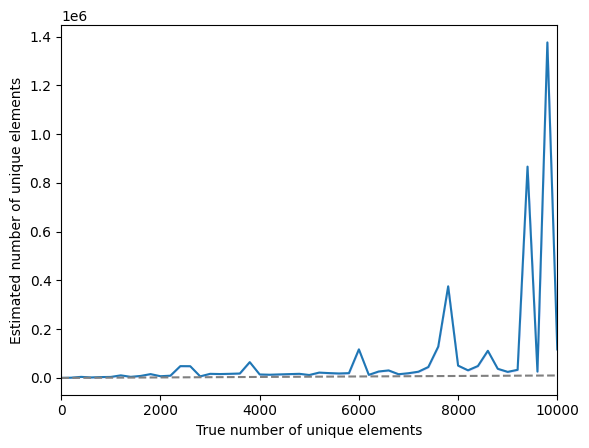

In [6]:
counter = ProbabilisticCounting()
simulate_and_visualize(counter)

# Implement Probabilistic Counting with multiple Hashes

In [7]:
class ProbabilisticCountingMultipleHashes:
    
    def __init__(self, nr_hash_functions):
        self.max_nr_of_leading_zeros = [0] * nr_hash_functions
        self.salts = ["".join(random.choice(string.ascii_lowercase) for _ in range(8))  for _ in range(nr_hash_functions)]
        self.hash_functions = [partial(self._base_hash_function, salt=salt) for salt in self.salts]
        
    def _base_hash_function(self, item, salt):
        return int(sha256(item.encode() + salt.encode()).hexdigest(), 16)
        
    def _number_of_leading_zeros(self, number):
        i = 0
        while number & 1 == 0:
            number >>= 1
            i += 1
        return i
    
    def add(self, item):
        for i, hash_function in enumerate(self.hash_functions):
            hash_value = hash_function(item)
            number_of_leading_zeros = self._number_of_leading_zeros(hash_value)
            if number_of_leading_zeros > self.max_nr_of_leading_zeros[i]:
                self.max_nr_of_leading_zeros[i] = number_of_leading_zeros
    
    def estimate_count(self):
        return np.median([2 ** x for x in self.max_nr_of_leading_zeros])
    
    def reset(self):
        self.max_nr_of_leading_zeros = [0] * len(self.hash_functions)

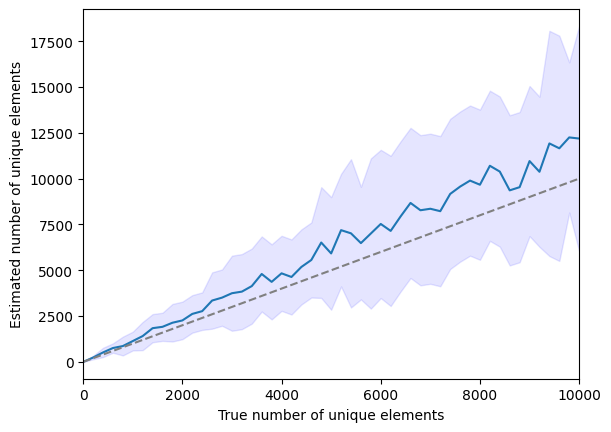

In [8]:
counter_multiple_hashes = ProbabilisticCountingMultipleHashes(10)
simulate_and_visualize(counter_multiple_hashes)

# Implement HyperLogLog

In [9]:
class HyperLogLog:
    
    def __init__(self):
        self.bits_bin = 4
        self.bin_count = 16
        self.max_nr_of_leading_zeros = [0] * self.bin_count
        self.hash_function = lambda x: int(sha256(x.encode()).hexdigest(), 16)
        
    def _number_of_leading_zeros(self, number):
        i = 0
        while number & 1 == 0:
            number >>= 1
            i += 1
        return i
    
    def add(self, item):
        hash_value = self.hash_function(item)
        index = hash_value & (self.bin_count - 1)
        number_of_leading_zeros = self._number_of_leading_zeros(hash_value >> self.bits_bin)
        if number_of_leading_zeros > self.max_nr_of_leading_zeros[index]:
            self.max_nr_of_leading_zeros[index] = number_of_leading_zeros
            
    def _bin_compensator(self, bins):
        try:
            return {
                16: 0.673,
                32: 0.697,
                64: 0.709
            }[bins]
        except KeyError:
            if (bins >= 128):
                return 0.7212 / (1 + 1.079 / bins)
    
    def estimate_count(self):
        def harmonic_average(bins):
            return sum(map(lambda b: 2 ** (-1 * (1 + b)), bins)) ** -1
        return self._bin_compensator(self.bin_count) * (self.bin_count ** 2) * harmonic_average(self.max_nr_of_leading_zeros)
    
    def reset(self):
        self.max_nr_of_leading_zeros = [0] * self.bin_count

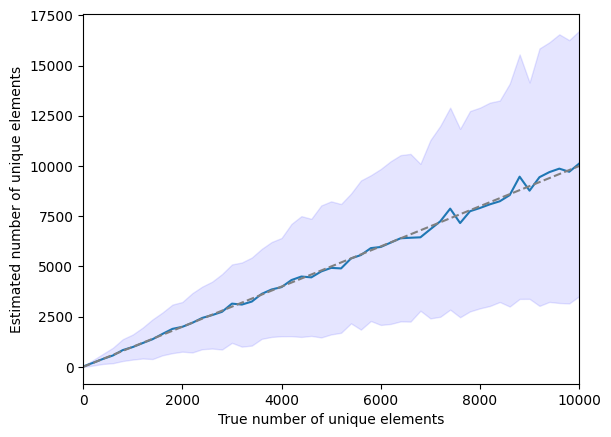

In [10]:
counter_hyperloglog = HyperLogLog()
simulate_and_visualize(counter_hyperloglog)